In [1]:
import pandas as pd
import numpy as np

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors
from matplotlib.patches import Rectangle
from matplotlib.lines import Line2D
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter, AutoMinorLocator)

from uncertainties import ufloat
from uncertainties.umath import * 
from scipy.optimize import curve_fit
from scipy.integrate import trapz

import sys
sys.path.append('../src')  # Add the path to where the python scripts are located
from constants import *  
from radiative import *
from utils import *
from plot_utils import nice_fonts

In [4]:
# Simple check of the S_ff function:
D = 100 * pc
R_star = 1.3 * au
T_star = 2200      # K
R_beam = 0.5 * au  # Beam size, to be updated
T_beam = 3500      # K , measured brightness temperature in the beam with the hot spot

H_hs = R_beam*0.1     # Depth of the hot spot
n_hs = 1E12           # Density of the hot spot

Mdot_dust = 3e-10 # in Msun/yr
vExp = 10         # in km/s
Rin = 5.0         # in au
Rout = 1e6        # in au
kappaFile = "0.09mu-0.11mu_MgFeSiO4_dens_HSD_new.opacity"

def S_Jy(nu, x_hs=0.2):
    T_hs = calc_T_hs(T_star, T_beam, x_hs)
    return S_ff_withStar(nu=nu, R=R_beam, H=H_hs, D=D, T_s=T_star, T=T_hs, n=n_hs, R_s=R_star)

def S_Jy_abs(nu, x_hs):
    S_unabs = S_Jy(nu, x_hs)
    return CircumstellarDustExtinction(S_unabs, nu, Mdot_dust, vExp, Rin, Rout, kappaFile)

T_hs=3.5e+04


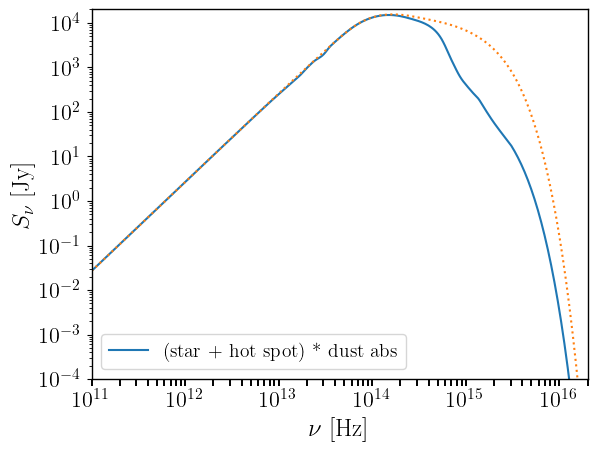

In [8]:
x_hs = 0.2
T_hs = calc_T_hs(T_star, T_beam, x_hs)
print(f'{T_hs=:.1e}')

# Calculate the SED
nu = np.geomspace(1e11,2e16,300)

# Plot data and fit
fig, ax = plt.subplots(1)
plt.gca().set_xlabel(r'$\nu$ [Hz]')
plt.gca().set_ylabel(r'$S_\nu$ [Jy]')
plt.plot(nu, S_Jy_abs(nu, x_hs), label = '(star + hot spot) * dust abs')
plt.plot(nu, S_Jy(nu, x_hs), linestyle=':')
plt.title('')
plt.xlim(nu[0], nu[-1])
plt.ylim(1e-4, 2e4)

plt.legend(loc='best')
ax.loglog()
plt.show()

In [ ]:
# The nsc parameter is defined in constants.py
nu1 = 1.157e15  # UVW1    
nu2 = 1.345e15  # UVM2 
nu = np.array( [nu1/nsc, nu2/nsc] )              # Transform to units of 1e15 Hz

flux1 = 1.64e0 * mJy    # in erg/s/cm2/Hz = Jy 
flux1_err = np.sqrt(0.03e0**2 + 0.05e0**2) * mJy  # in erg/s/cm2/Hz

flux2 = 7.97e-2 * mJy   # in erg/s/cm2/Hz 
flux2_err = np.sqrt(0.28e-2**2 + 0.05e-2**2) * mJy # in erg/s/cm2/Hz

print(f'flux1={flux1/mJy} ± {flux1_err/mJy:.2f} mJy')
print(f'flux2={flux2/mJy:.3f} ± {flux2_err/mJy:.3f} mJy')

## Model for a random system

In [4]:
# System parameters
D = 2.0 * kpc
T_e = 1e4
theta_s = 30.0 #arcsec
R_s = theta_s * (D/pc) * au  # R_s[AU] = theta_s[arcsec] * D[pc]

# Observations to fit
nu = np.array( [325e6, 735e6, 1260e6, 4.8e9, 8.4e9] ) # in Hz
S = np.array( [1.6, 3.3, 4.0, 3.9, 3.5] )      # in Jy
S_err = np.array( [0.1*flux for flux in S] ) # assume a 10% calibration error

In [5]:
# Model fitting

# Define seed values for the fit
seed = np.array([2]) # log(n)
bs = ((1), (5)) # ( min values, max values ) = ( (min_n, ...), (max_n, ...) )

# Fit function S_ff(nu, R, D, Te, n) to the data  
popt, pcov = curve_fit( lambda x, logn: S_ff(x,R_s,D,T_e,10**logn), xdata=nu, ydata=S, p0=seed, sigma=S_err, bounds=bs, absolute_sigma=True)
perr = np.sqrt(np.diag(pcov))
    
n = ufloat(10**popt[0], 10**popt[0] * perr[0]) # I fit log(n), so the error delta(logn) = (delta n)/n

print(f'Density: {n = :.2u}')

# prepare confidence level curves
nstd = 1.0 # to draw 1-sigma intervals
popt_up = popt + nstd * perr
popt_dw = popt - nstd * perr

nu_fit = np.geomspace( min(nu)/1.5, max(nu)*5., 100)
fit = S_ff(nu_fit, R_s,D,T_e, n.nominal_value)
fit_up = S_ff(nu_fit, R_s,D,T_e, 10**popt_up[0])
fit_dw = S_ff(nu_fit, R_s,D,T_e, 10**popt_dw[0])


Density: n = 3283+/-38


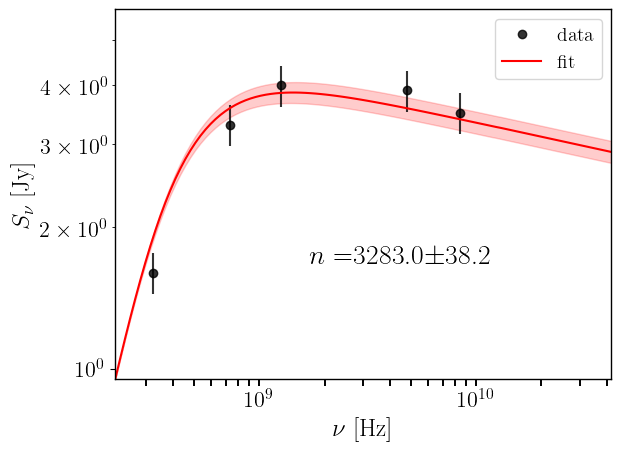

In [6]:
# Plot data and fit

fig, ax = plt.subplots(1)
plt.gca().set_xlabel(r'$\nu$ [Hz]')
plt.gca().set_ylabel(r'$S_\nu$ [Jy]')
plt.errorbar(nu, S, yerr=S_err, ecolor='k', alpha=0.8, fmt='none')
plt.plot(nu, S, 'ko', alpha=0.8, label = 'data')
plt.plot(nu_fit, fit, 'r-', label='fit')
ax.fill_between(nu_fit, fit_up, fit_dw, alpha=.2, label='', color='r')
plt.title('')
plt.xlim(nu_fit[0], nu_fit[-1])
plt.ylim(min(fit), 1.5*max(fit))

plt.legend(loc='best')
ax.loglog()
ax.annotate(r'$n =$' + str(round(abs(n.nominal_value),1)) + '$\pm$' + str(round(n.std_dev,1)),
            xy=(0.35, 0.25), xycoords='axes fraction',
            xytext=(20, 20), textcoords='offset pixels',
            horizontalalignment='left',
            verticalalignment='bottom')

plt.show()